<a href="https://colab.research.google.com/github/neennera/AI_pitch/blob/main/aib_neen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 20 11:39:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [120]:
!rsync -ah --progress /content/drive/MyDrive/AI/processed_train /content

sending incremental file list
rsync: change_dir "/content/drive/MyDrive/AI" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1196) [sender=3.1.2]


In [18]:
import zipfile
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

# Model

In [179]:
import os
import time

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset


class CustomTrainDataset(Dataset):
    def __init__(self, train_name,feat_path , label_path):
        #self.img_labels = os.listdir(feat_path)
        self.img_labels = train_name
        self.feat_path = feat_path 
        self.label_path = label_path

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        #data = torch.from_numpy(pd.read_csv(self.feat_path + self.img_labels[idx]).values.astype(np.float32))
        #label = torch.from_numpy(pd.read_csv(self.label_path + self.img_labels[idx]).values.astype(np.float32))
        data = (data - data.mean(0)) / (data.std(0) + 1e-6)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, test_name,feat_path , label_path):
        #self.img_labels = os.listdir(feat_path)
        self.img_labels = test_name
        self.feat_path = feat_path 
        self.label_path = label_path

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        #data = torch.from_numpy(pd.read_csv(self.feat_path + self.img_labels[idx]).values.astype(np.float32))
        #label = torch.from_numpy(pd.read_csv(self.label_path + self.img_labels[idx]).values.astype(np.float32))
        data = (data - data.mean(0)) / (data.std(0) + 1e-6)
        return data, label

In [210]:
train_feat_path='/content/gdrive/MyDrive/AI/processed_train/feat/'
train_label_path='/content/gdrive/MyDrive/AI/processed_train/label/'
test_feat_path='/content/gdrive/MyDrive/AI/processed_test/feat/'
test_label_path='/content/gdrive/MyDrive/AI/processed_test/label/'

train_name=os.listdir(train_feat_path)
train_name2=os.listdir(train_label_path)
test_name=os.listdir(test_feat_path)
test_name2=os.listdir(test_label_path)

In [211]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

train_name = intersection(train_name,train_name2)
test_name = intersection(test_name,test_name2)

In [212]:
train_dataset=CustomTrainDataset(train_name,train_feat_path, train_label_path)
test_dataset=CustomTrainDataset(test_name,test_feat_path, test_label_path)

In [215]:
len(train_name) == len(os.listdir(train_feat_path))
#len(test_name) == len(os.listdir(test_feat_path))

False

# Model

In [217]:
class Model(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()

        self.convo1 = self._get_conv_block(feat_dim, 512, 7)
        self.convo2 = self._get_conv_block(512, 512, 7)
        self.convo3 = self._get_conv_block(512, 512, 7)
        self.convo4 = self._get_conv_block(512, 512, 7)
        self.convo5 = self._get_conv_block(512, 2048, 32)
        self.convo6 = self._get_conv_block(2048, 2048, 1)
        self.convo7 = self._get_conv_block(2048, 88, 1, activation="sigmoid")

        # self.lstm = nn.LSTM(input_size=512, hidden_size=512, bidirectional=True, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=1024, hidden_size=88, batch_first=True)

    def _get_activation(self, name):
      if name == "relu":
        return nn.ReLU()
      elif name == "sigmoid":
        return nn.Sigmoid()

    def _get_conv_block(self, in_channel, out_channel, kernel_size, activation="relu"):
      return nn.Sequential(
          nn.Conv1d(in_channel, out_channel, kernel_size, padding="same"),
          nn.BatchNorm1d(out_channel),
          self._get_activation(activation)
      )

    def forward(self, x):
        x = torch.transpose(x, 1, 2)  # reformat from (B, T, C) to (B, C, T)
        # x.shape = (batch_size, 256, 500)
        x = self.convo1(x)   # (B, C=120, T=1500) -> (B, C=conv1_out_dim, T=1500)
        x = self.convo2(x)
        x = self.convo3(x)
        x = self.convo4(x)
        x = self.convo5(x)
        x = self.convo6(x)
        x = self.convo7(x)
       
        x = torch.transpose(x, 1, 2)  # convert (B, C, T) -> (B, T, C)
        # x, _ = self.lstm(x)  # lstm return [output, (h, c)]
        # x, _ = self.lstm2(x) 
        return x

In [218]:
checkpoint = { 
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

def save(train_losses,metrics,baseline,i):
    loss_log=[]
    acc_log=[]
    baseline_log=[]
    
    path='/content/gdrive/MyDrive/AI/weight/P'+str(i)+'/checkpoint.pth'
    path_log='/content/gdrive/MyDrive/AI/weight/P'+str(i)
    path_old='/content/gdrive/MyDrive/AI/weight/P'+str(i-1)
    torch.save(checkpoint, path)

    
    with open(path_old+'baseline_log.pkl', 'rb') as f:
        baseline_log = pickle.load(f)
    with open(path_old+'loss_log.pkl', 'rb') as f:
        loss_log = pickle.load(f)
    with open(path_old+'acc_log.pkl', 'rb') as f:
        acc_log = pickle.load(f)
    
        

    for k in train_losses :
        loss_log.append(k)
    acc_log = acc_log + metrics
    baseline_log = baseline_log + baseline

    with open(path_log+'/baseline_log.pkl', 'wb') as f:
        pickle.dump(baseline_log, f)
    with open(path_log+'/loss_log.pkl', 'wb') as f:
        pickle.dump(loss_log, f)
    with open(path_log+'/acc_log.pkl', 'wb') as f:
        pickle.dump(acc_log, f)

In [221]:
def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    correct = (predictions >= 0.5) == true_values
    return correct.mean().item()

In [224]:
from tqdm.auto import tqdm


def train_model(model, train_dataloader, val_dataloader, epochs, learning_rate=3e-4, save_every=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.to(device)
    # loss_fn = nn.MSELoss()
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # initialize loss log
    train_losses = []
    val_losses = []
    metrics = []
    baseline = []
    
    # iterate over epoch
    for epoch in range(epochs):
        train_batch_loss = []
        train_batch_acc = []
        
        # iterate over batch in dataset
        for xb, yb in tqdm(train_dataloader) :
        #for xb, yb in enumerate(tqdm(train_dataloader)):
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            
            # forward pass
            y_hatb = model(xb)
            loss = loss_fn(y_hatb, yb)
            acc = M_accuracy(y_hatb.cpu(), yb.cpu())
            
            loss.backward()
            optimizer.step()
            
            loss_logger = loss.detach().cpu().numpy()
            train_batch_loss.append(loss_logger)
            train_losses.append(loss_logger)
            metrics.append(acc)
            baseline.append(loss_fn(torch.zeros_like(yb), yb))
        train_epoch_loss = np.mean(train_batch_loss)
        
        val_batch_loss = []
        for xb, yb in tqdm(val_dataloader):
            xb = xb.to(device)
            yb = yb.to(device)
            
            with torch.no_grad():
                y_hatb = model(xb)
                loss = loss_fn(y_hatb, yb)
                loss_logger = loss.detach().cpu().numpy()
            val_batch_loss.append(loss_logger)
        val_epoch_loss = np.mean(val_batch_loss)
        
        val_losses.append(val_epoch_loss)
        if (epoch>3 and epoch%5 == 0) :
          save(train_losses,metrics,baseline ,epoch/5)
        print(f"[Epoch {epoch} / {epochs}] Training Loss: {train_epoch_loss:.6f}\tValidation Loss: {val_epoch_loss:.6f}")
        
    return {
        "train_loss": train_losses,
        "val_loss": val_losses
    }

In [ ]:
batch_size = 64
epochs = 50
num_workers = 0

model = Model()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
history = train_model(model,train_dataloader,test_dataloader,50)

  0%|          | 0/15 [00:00<?, ?it/s]

In [109]:
from tqdm.auto import tqdm

def train_model(epochs=10) :
    learning_rate=3e-4
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
    val_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model=Model()
    model = model.to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # initialize loss log
    train_losses = []
    val_losses = []
    metrics = []
    baseline = []
    
    # iterate over epoch
    for epoch in range(epochs):
        train_batch_loss = []
        train_batch_acc = []
        
        # iterate over batch in dataset
        #for xb, yb in tqdm(train_dataloader):
        for xb, yb in train_dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            
            # forward pass
            y_hatb = model(xb)
            loss = loss_fn(y_hatb, yb)
            acc = M_accuracy(y_hatb, yb)
            
            loss.backward()
            optimizer.step()
            
            loss_logger = loss.detach().cpu().numpy()
            train_batch_loss.append(loss_logger)
            train_losses.append(loss_logger)
            metrics.append(acc)
            baseline.append(loss_fn(torch.zeros_like(yb), yb))
        
        train_epoch_loss = np.mean(train_batch_loss)
        
        val_batch_loss = []
        for xb, yb in tqdm(val_dataloader):
            xb = xb.to(device)
            yb = yb.to(device)
            
            with torch.no_grad():
                y_hatb = model(xb)
                loss = loss_fn(y_hatb, yb)
                loss_logger = loss.detach().cpu().numpy()
            val_batch_loss.append(loss_logger)
        val_epoch_loss = np.mean(val_batch_loss)
        
        val_losses.append(val_epoch_loss)
        if (epoch>3 and epoch%5 == 0) :
          save(train_losses,metrics,baseline ,epoch/5)
        print(f"[Epoch {epoch} / {epochs}] Training Loss: {train_epoch_loss:.6f}\tValidation Loss: {val_epoch_loss:.6f}")
        
    return {
        "train_loss": train_losses,
        "val_loss": val_losses
    }

# Train

In [ ]:
i = 0
checkpoint = torch.load('/content/drive/MyDrive/AI/weight/'+i+'.pth')
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/final.pt")

In [ ]:
with open("/content/drive/MyDrive/visai/history.pckl", "wb") as fp:
  pickle.dump(history, fp)

In [ ]:
xb, yb = next(iter(train_dataloader))

In [ ]:
yhatb = model(xb.cuda())

In [ ]:
yhatb

tensor([[[0.3199, 0.3188, 0.3187,  ..., 0.3191, 0.3194, 0.3188],
         [0.2767, 0.2764, 0.2764,  ..., 0.2766, 0.2768, 0.2765],
         [0.2701, 0.2700, 0.2700,  ..., 0.2701, 0.2701, 0.2701],
         ...,
         [0.2689, 0.2689, 0.2689,  ..., 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2689, 0.2689,  ..., 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2690, 0.2690,  ..., 0.2690, 0.2690, 0.2690]],

        [[0.3200, 0.3188, 0.3187,  ..., 0.3191, 0.3194, 0.3189],
         [0.2767, 0.2764, 0.2764,  ..., 0.2766, 0.2768, 0.2765],
         [0.2701, 0.2700, 0.2700,  ..., 0.2701, 0.2701, 0.2701],
         ...,
         [0.2689, 0.2689, 0.2689,  ..., 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2689, 0.2689,  ..., 0.2689, 0.2689, 0.2689],
         [0.2689, 0.2690, 0.2690,  ..., 0.2690, 0.2690, 0.2690]],

        [[0.3199, 0.3188, 0.3187,  ..., 0.3191, 0.3194, 0.3188],
         [0.2767, 0.2764, 0.2764,  ..., 0.2766, 0.2768, 0.2765],
         [0.2701, 0.2700, 0.2700,  ..., 0.2701, 0.2701, 0.

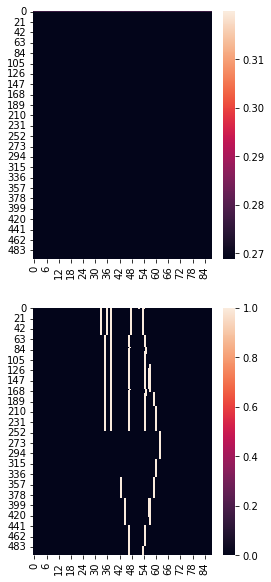

In [ ]:
import seaborn as sns

idx = 5
fig, ax = plt.subplots(2, 1, figsize=(4, 10))

sns.heatmap(yhatb.detach().cpu().numpy()[idx], ax=ax[0])
sns.heatmap(yb[idx], ax=ax[1])